In [3]:
import os
import numpy as np
import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader, WeightedRandomSampler

import sys 
sys.path.append('..')

# Reference: https://github.com/alexeybokhovkin/DeepSDF

In [4]:
from models import SingleShapeDecoder
from utils.dataset import SingleShapeData
import utils.dataset
from trainer import SdfTrainerShape

In [5]:
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

# HACKS!
# MOVE TO CONFIG FILE
DATADIR = '/home/ninad/Desktop/Docs/phd-res/proj-irvl-grasp-transfer/code/docker-data/output_dataset'
OBJ_MODEL = '003_cracker_box_google_16k_textured_scale_1000'
GRIPPER = 'fetch_gripper'
GRASP_IDX = 0

In [6]:
validation_fraction = 0.3
batch_size = 16384
trn_steps = 400
val_steps = 200

In [7]:
trn_data, val_data = utils.dataset.train_val_split(
    utils.dataset.load_from_npz(DATADIR, OBJ_MODEL, GRIPPER, GRASP_IDX),
    val_fraction=validation_fraction)

trn_query, trn_sdf_obj, trn_sdf_grp = utils.dataset.format_data(trn_data)
val_query, val_sdf_obj, val_sdf_grp = utils.dataset.format_data(val_data)

trn_weights = utils.dataset.get_weights(trn_sdf_obj)
val_weights = utils.dataset.get_weights(val_sdf_obj)

trn_dataset = SingleShapeData(trn_query, trn_sdf_obj)
val_dataset = SingleShapeData(val_query, val_sdf_obj)

trn_sampler = WeightedRandomSampler(trn_weights, batch_size*trn_steps)
val_sampler = WeightedRandomSampler(val_weights, batch_size*val_steps)

trn_loader = DataLoader(trn_dataset, batch_size=batch_size, sampler=trn_sampler, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, sampler=val_sampler, num_workers=4)

In [8]:
model = SingleShapeDecoder(output_dim=1).cuda()
criterion = nn.MSELoss()
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)
epochs = 8
delta = 0.1

In [9]:
sdf_trainer = SdfTrainerShape(model, criterion, optimizer, delta)
sdf_trainer.fit(trn_loader, val_loader, epochs, save=True)

  0%|          | 0/400 [00:00<?, ?it/s]

val loss: 0.00005, val mse: 5.58933


  0%|          | 0/400 [00:00<?, ?it/s]

val loss: 0.00003, val mse: 8.87350


  0%|          | 0/400 [00:00<?, ?it/s]

val loss: 0.00002, val mse: 4.61061


  0%|          | 0/400 [00:00<?, ?it/s]

val loss: 0.00003, val mse: 4.81837


  0%|          | 0/400 [00:00<?, ?it/s]

val loss: 0.00003, val mse: 6.17335


  0%|          | 0/400 [00:00<?, ?it/s]

val loss: 0.00003, val mse: 6.99880


  0%|          | 0/400 [00:00<?, ?it/s]

val loss: 0.00003, val mse: 23.29628


  0%|          | 0/400 [00:00<?, ?it/s]

val loss: 0.00003, val mse: 26.44951


In [10]:


import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline



In [11]:


def plot_sdf(xyz, sdf, n_display=10000):
    fig = plt.figure(figsize = (10,10))
    ax = fig.add_subplot(111, projection='3d')
    

    ind = np.random.choice(range(xyz.shape[0]), n_display)
    data = xyz[ind].T

    ax.scatter(data[0], data[2], data[1], s=5, c=sdf[ind])
    ax.view_init(20, 100)
    limit = (-0.3, 0.3)
    ax.set_xlim3d(*limit)
    ax.set_ylim3d(*limit)
    ax.set_zlim3d(*limit)

    plt.show()



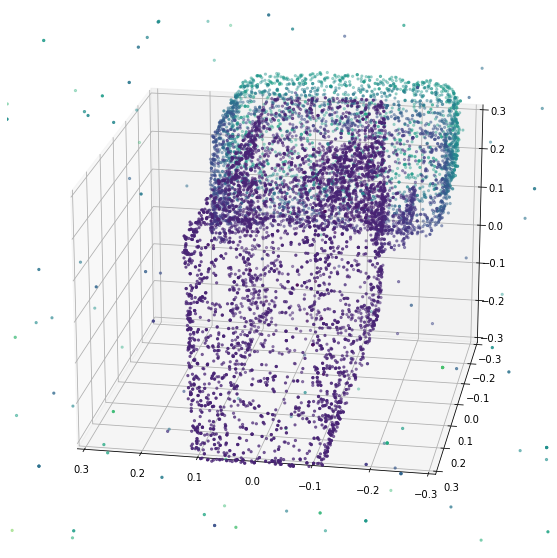

In [12]:
x, y = next(iter(val_loader))
plot_sdf(x.numpy(), y.numpy().squeeze())

In [13]:
sdf_values = model(x.float().cuda()) # model predictions
sdf_values = sdf_values.detach().cpu().numpy()


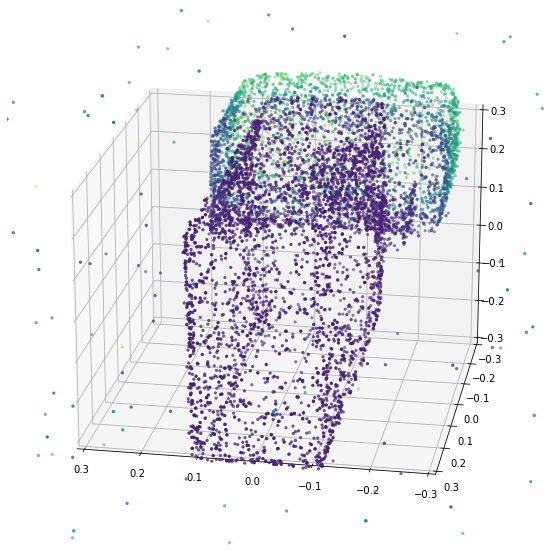

In [14]:
plot_sdf(x.numpy(), sdf_values.squeeze())

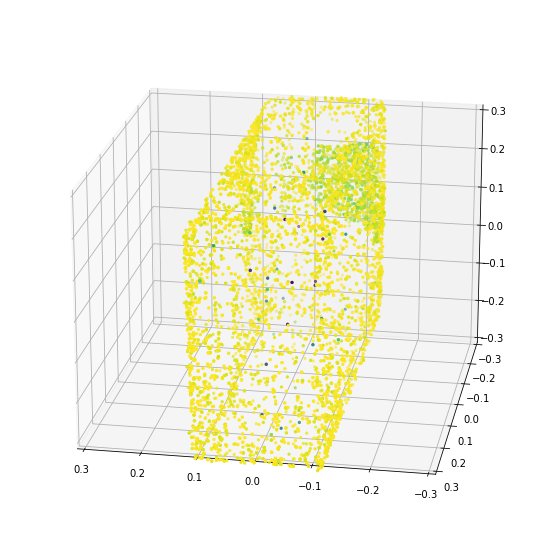

In [17]:
ind = y.squeeze()<=0
plot_sdf(x[ind, :].numpy(), y[ind,:].squeeze())


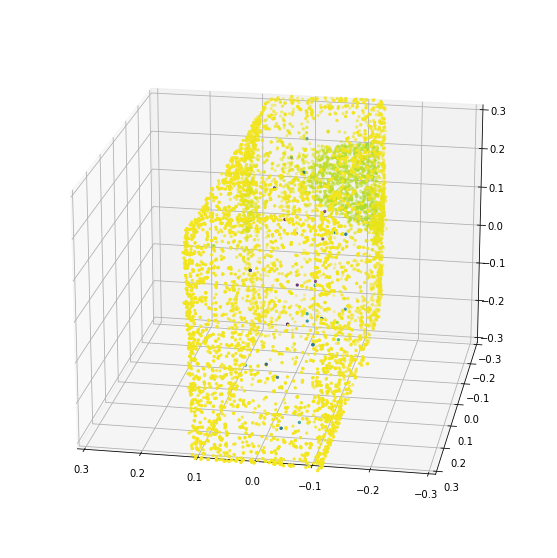

In [18]:
ind = sdf_values.squeeze()<=0
plot_sdf(x.numpy()[ind, :], sdf_values[ind].squeeze())
